In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from google.colab import drive
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
num_epochs = 60
learning_rate = 0.001
batch_size = 32
use_cbam = True

In [5]:
if use_cbam:
  results_filename = '/content/gdrive/My Drive/Deep Learning/Project/CIFAR100/Results_CBAM.csv'
  models_dirname = '/content/gdrive/My Drive/Deep Learning/Project/CIFAR100/Models/CBAM'
else:
  results_filename = '/content/gdrive/My Drive/Deep Learning/Project/CIFAR100/Results_NO_CBAM.csv'
  models_dirname = '/content/gdrive/My Drive/Deep Learning/Project/CIFAR100/Models/NO_CBAM'

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
classes = trainset.classes

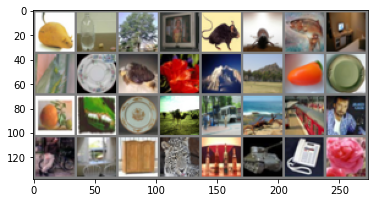

 pear bottle oak_tree television mouse beetle trout television caterpillar plate turtle tulip mountain mountain sweet_pepper plate orange caterpillar plate camel streetcar lobster train   man   man table wardrobe leopard bottle  tank telephone tulip


In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [9]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=1, groups=1)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out)
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        x_out = self.SpatialGate(x_out)
        return x_out

In [10]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes, use_cbam):
        self.use_cbam = use_cbam
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64,  layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.fc = nn.Linear(512 * block.expansion, num_classes)

        init.kaiming_normal(self.fc.weight)
        for key in self.state_dict():
            if key.split('.')[-1]=="weight":
                if "conv" in key:
                    init.kaiming_normal(self.state_dict()[key], mode='fan_out')
                if "bn" in key:
                    if "SpatialGate" in key:
                        self.state_dict()[key][...] = 0
                    else:
                        self.state_dict()[key][...] = 1
            elif key.split(".")[-1]=='bias':
                self.state_dict()[key][...] = 0

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_cbam = self.use_cbam))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_cbam = self.use_cbam))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)

        x = self.layer2(x)

        x = self.layer3(x)

        x = self.layer4(x)

        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [11]:
net = ResNet(BasicBlock, [3, 4, 6, 3], len(classes), use_cbam=use_cbam)
net.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print("Model Initialised")

Model Initialised


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [13]:
results = pd.DataFrame(columns=["Epoch", "Trainset Top1 Error", "Testset Top1 Error", "Trainset Top5 Error", "Testset Top5 Error", "Trainset Loss", "Testset Loss", "Trainset Accuracy", "Testset Accuracy", "Trainset Classwise Accuracy", "Testset Classwise Accuracy"])

In [ ]:
for epoch in range(num_epochs):

  running_loss = 0.0
  total = 0
  correct = 0
  correct5 = 0
  classwise_correct = {key: 0 for key in classes}
  classwise_total = {key: 0 for key in classes}

  print(f"\nEpoch {epoch+1}\n")

  print("\nTraining\n")

  for data in tqdm(trainloader):
      inputs, labels = data
      if torch.cuda.is_available():
          inputs, labels = inputs.cuda(), labels.cuda()

      optimizer.zero_grad()

      outputs = net(inputs)

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      for i in range(labels.size(0)):
        label = classes[labels[i].item()]
        classwise_correct[label] += (predicted[i].item() == labels[i].item())
        classwise_total[label] += 1

        correct5 += (labels[i].item() in outputs[i].data.cpu().numpy().argsort()[-5:])

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
  
  train_loss = running_loss
  train_accuracy = (correct/total)*100
  train_classwise_accuracy = {key: ((classwise_correct[key]/classwise_total[key])*100) for key in classes}
  train_top1 = 100 - train_accuracy
  train_top5 = (1 - (correct5 / total) ) * 100

  print(f"\nLoss = {train_loss}, Accuracy = {train_accuracy}\n")
  print(f"\nClasswise Accuracy = {train_classwise_accuracy}\n")
  print(f"\nTop-1 Error %% = {train_top1}\n")
  print(f"\nTop-5 Error %% = {train_top5}\n")

  running_loss = 0.0
  total = 0
  correct = 0
  correct5 = 0
  classwise_correct = {key: 0 for key in classes}
  classwise_total = {key: 0 for key in classes}

  print("\nTesting\n")

  with torch.no_grad():
    for data in tqdm(testloader):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs = net(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
          label = classes[labels[i].item()]
          classwise_correct[label] += (predicted[i].item() == labels[i].item())
          classwise_total[label] += 1

          correct5 += (labels[i].item() in outputs[i].data.cpu().numpy().argsort()[-5:])

        loss = criterion(outputs, labels)
        running_loss += loss.item()
  
  test_loss = running_loss
  test_accuracy = (correct/total)*100
  test_classwise_accuracy = {key: ((classwise_correct[key]/classwise_total[key])*100) for key in classes}
  test_top1 = 100 - test_accuracy
  test_top5 = (1 - (correct5 / total) ) * 100

  print(f"\nLoss = {test_loss}, Accuracy = {test_accuracy}\n")
  print(f"\nClasswise Accuracy = {test_classwise_accuracy}\n")
  print(f"\nTop-1 Error %% = {test_top1}\n")
  print(f"\nTop-5 Error %% = {test_top5}\n")

  results = results.append({"Epoch": (epoch+1), \
                            "Trainset Top1 Error": train_top1, "Testset Top1 Error": test_top1, \
                            "Trainset Top5 Error": train_top5, "Testset Top5 Error": test_top5, \
                            "Trainset Loss": train_loss, "Testset Loss": test_loss, \
                            "Trainset Accuracy": train_accuracy, "Testset Accuracy": test_accuracy, \
                            "Trainset Classwise Accuracy": train_classwise_accuracy, "Testset Classwise Accuracy": test_classwise_accuracy}, \
                           ignore_index=True)
  
  torch.save(net.state_dict(), models_dirname+f"/{epoch+1}.pth")
  results.to_csv(results_filename)


Epoch 1


Training





Loss = 6139.729823350906, Accuracy = 10.814


Classwise Accuracy = {'apple': 24.2, 'aquarium_fish': 11.799999999999999, 'baby': 8.6, 'bear': 1.6, 'beaver': 1.2, 'bed': 2.8000000000000003, 'bee': 2.4, 'beetle': 2.8000000000000003, 'bicycle': 1.4000000000000001, 'bottle': 3.2, 'bowl': 0.0, 'boy': 0.6, 'bridge': 3.8, 'bus': 4.6, 'butterfly': 10.2, 'camel': 3.0, 'can': 5.0, 'castle': 15.4, 'caterpillar': 17.599999999999998, 'cattle': 0.4, 'chair': 34.599999999999994, 'chimpanzee': 22.2, 'clock': 0.8, 'cloud': 33.6, 'cockroach': 26.0, 'couch': 1.0, 'crab': 1.4000000000000001, 'crocodile': 12.0, 'cup': 3.2, 'dinosaur': 3.5999999999999996, 'dolphin': 22.0, 'elephant': 4.0, 'flatfish': 0.0, 'forest': 16.6, 'fox': 3.8, 'girl': 1.6, 'hamster': 17.599999999999998, 'house': 7.000000000000001, 'kangaroo': 5.2, 'keyboard': 1.6, 'lamp': 1.4000000000000001, 'lawn_mower': 29.799999999999997, 'leopard': 14.799999999999999, 'lion': 20.0, 'lizard': 0.6, 'lobster': 3.2, 'man': 2.1999999999999997, 'maple_



Loss = 1115.098462820053, Accuracy = 16.55


Classwise Accuracy = {'apple': 44.0, 'aquarium_fish': 28.000000000000004, 'baby': 23.0, 'bear': 1.0, 'beaver': 2.0, 'bed': 19.0, 'bee': 4.0, 'beetle': 5.0, 'bicycle': 0.0, 'bottle': 20.0, 'bowl': 0.0, 'boy': 0.0, 'bridge': 12.0, 'bus': 16.0, 'butterfly': 8.0, 'camel': 3.0, 'can': 7.000000000000001, 'castle': 4.0, 'caterpillar': 42.0, 'cattle': 1.0, 'chair': 46.0, 'chimpanzee': 42.0, 'clock': 0.0, 'cloud': 55.00000000000001, 'cockroach': 31.0, 'couch': 4.0, 'crab': 3.0, 'crocodile': 14.000000000000002, 'cup': 9.0, 'dinosaur': 4.0, 'dolphin': 28.000000000000004, 'elephant': 8.0, 'flatfish': 2.0, 'forest': 18.0, 'fox': 0.0, 'girl': 9.0, 'hamster': 11.0, 'house': 0.0, 'kangaroo': 10.0, 'keyboard': 3.0, 'lamp': 1.0, 'lawn_mower': 44.0, 'leopard': 16.0, 'lion': 28.000000000000004, 'lizard': 1.0, 'lobster': 2.0, 'man': 11.0, 'maple_tree': 25.0, 'motorcycle': 20.0, 'mountain': 28.000000000000004, 'mouse': 0.0, 'mushroom': 18.0, 'oak_tree': 62.0, '



Loss = 5245.457099676132, Accuracy = 20.024


Classwise Accuracy = {'apple': 39.6, 'aquarium_fish': 23.799999999999997, 'baby': 17.8, 'bear': 3.8, 'beaver': 8.4, 'bed': 13.0, 'bee': 9.6, 'beetle': 14.2, 'bicycle': 13.600000000000001, 'bottle': 26.200000000000003, 'bowl': 0.6, 'boy': 4.0, 'bridge': 20.0, 'bus': 22.8, 'butterfly': 20.0, 'camel': 12.2, 'can': 15.0, 'castle': 34.599999999999994, 'caterpillar': 24.0, 'cattle': 4.8, 'chair': 39.4, 'chimpanzee': 41.0, 'clock': 1.4000000000000001, 'cloud': 47.599999999999994, 'cockroach': 43.4, 'couch': 6.4, 'crab': 1.4000000000000001, 'crocodile': 12.8, 'cup': 13.200000000000001, 'dinosaur': 11.200000000000001, 'dolphin': 26.200000000000003, 'elephant': 7.199999999999999, 'flatfish': 2.4, 'forest': 22.6, 'fox': 3.5999999999999996, 'girl': 6.4, 'hamster': 25.4, 'house': 14.799999999999999, 'kangaroo': 15.0, 'keyboard': 6.800000000000001, 'lamp': 4.0, 'lawn_mower': 48.0, 'leopard': 16.2, 'lion': 26.200000000000003, 'lizard': 2.0, 'lobster': 7



Loss = 998.7403469085693, Accuracy = 23.01


Classwise Accuracy = {'apple': 52.0, 'aquarium_fish': 28.999999999999996, 'baby': 12.0, 'bear': 12.0, 'beaver': 10.0, 'bed': 18.0, 'bee': 27.0, 'beetle': 24.0, 'bicycle': 24.0, 'bottle': 38.0, 'bowl': 1.0, 'boy': 5.0, 'bridge': 11.0, 'bus': 32.0, 'butterfly': 17.0, 'camel': 10.0, 'can': 17.0, 'castle': 54.0, 'caterpillar': 14.000000000000002, 'cattle': 13.0, 'chair': 44.0, 'chimpanzee': 36.0, 'clock': 7.000000000000001, 'cloud': 59.0, 'cockroach': 50.0, 'couch': 6.0, 'crab': 5.0, 'crocodile': 17.0, 'cup': 15.0, 'dinosaur': 9.0, 'dolphin': 38.0, 'elephant': 5.0, 'flatfish': 8.0, 'forest': 33.0, 'fox': 9.0, 'girl': 30.0, 'hamster': 18.0, 'house': 11.0, 'kangaroo': 5.0, 'keyboard': 12.0, 'lamp': 10.0, 'lawn_mower': 48.0, 'leopard': 14.000000000000002, 'lion': 35.0, 'lizard': 0.0, 'lobster': 12.0, 'man': 2.0, 'maple_tree': 35.0, 'motorcycle': 42.0, 'mountain': 17.0, 'mouse': 0.0, 'mushroom': 18.0, 'oak_tree': 49.0, 'orange': 53.0, 'orchid': 41



Loss = 4644.389665722847, Accuracy = 26.945999999999998


Classwise Accuracy = {'apple': 50.2, 'aquarium_fish': 33.6, 'baby': 22.2, 'bear': 7.000000000000001, 'beaver': 11.0, 'bed': 24.8, 'bee': 19.400000000000002, 'beetle': 20.4, 'bicycle': 28.000000000000004, 'bottle': 37.0, 'bowl': 2.4, 'boy': 9.0, 'bridge': 23.799999999999997, 'bus': 33.6, 'butterfly': 23.0, 'camel': 14.6, 'can': 21.0, 'castle': 48.8, 'caterpillar': 20.8, 'cattle': 16.2, 'chair': 50.0, 'chimpanzee': 47.4, 'clock': 6.0, 'cloud': 50.2, 'cockroach': 60.8, 'couch': 10.6, 'crab': 7.199999999999999, 'crocodile': 24.2, 'cup': 20.4, 'dinosaur': 16.0, 'dolphin': 32.4, 'elephant': 22.0, 'flatfish': 9.2, 'forest': 36.6, 'fox': 10.0, 'girl': 14.2, 'hamster': 33.6, 'house': 19.8, 'kangaroo': 16.6, 'keyboard': 13.8, 'lamp': 8.799999999999999, 'lawn_mower': 54.6, 'leopard': 24.8, 'lion': 34.4, 'lizard': 3.8, 'lobster': 16.2, 'man': 10.0, 'maple_tree': 38.800000000000004, 'motorcycle': 49.8, 'mountain': 38.6, 'mouse': 3.2, 'mush



Loss = 900.6318261623383, Accuracy = 28.83


Classwise Accuracy = {'apple': 57.99999999999999, 'aquarium_fish': 51.0, 'baby': 26.0, 'bear': 18.0, 'beaver': 11.0, 'bed': 27.0, 'bee': 40.0, 'beetle': 31.0, 'bicycle': 35.0, 'bottle': 36.0, 'bowl': 4.0, 'boy': 9.0, 'bridge': 32.0, 'bus': 26.0, 'butterfly': 17.0, 'camel': 22.0, 'can': 28.000000000000004, 'castle': 55.00000000000001, 'caterpillar': 14.000000000000002, 'cattle': 20.0, 'chair': 60.0, 'chimpanzee': 55.00000000000001, 'clock': 11.0, 'cloud': 62.0, 'cockroach': 51.0, 'couch': 6.0, 'crab': 16.0, 'crocodile': 33.0, 'cup': 24.0, 'dinosaur': 22.0, 'dolphin': 43.0, 'elephant': 14.000000000000002, 'flatfish': 18.0, 'forest': 40.0, 'fox': 22.0, 'girl': 3.0, 'hamster': 26.0, 'house': 27.0, 'kangaroo': 15.0, 'keyboard': 11.0, 'lamp': 6.0, 'lawn_mower': 62.0, 'leopard': 27.0, 'lion': 24.0, 'lizard': 9.0, 'lobster': 5.0, 'man': 14.000000000000002, 'maple_tree': 42.0, 'motorcycle': 50.0, 'mountain': 35.0, 'mouse': 2.0, 'mushroom': 32.0, 'o



Loss = 4130.869266986847, Accuracy = 33.354


Classwise Accuracy = {'apple': 57.4, 'aquarium_fish': 41.6, 'baby': 26.0, 'bear': 14.6, 'beaver': 13.0, 'bed': 34.2, 'bee': 33.0, 'beetle': 30.0, 'bicycle': 36.4, 'bottle': 38.800000000000004, 'bowl': 8.0, 'boy': 13.0, 'bridge': 31.2, 'bus': 36.4, 'butterfly': 25.6, 'camel': 20.8, 'can': 31.8, 'castle': 56.599999999999994, 'caterpillar': 24.2, 'cattle': 27.0, 'chair': 53.2, 'chimpanzee': 54.800000000000004, 'clock': 15.4, 'cloud': 56.99999999999999, 'cockroach': 63.4, 'couch': 17.599999999999998, 'crab': 14.2, 'crocodile': 25.6, 'cup': 32.4, 'dinosaur': 29.799999999999997, 'dolphin': 37.8, 'elephant': 32.6, 'flatfish': 13.200000000000001, 'forest': 40.8, 'fox': 16.8, 'girl': 22.400000000000002, 'hamster': 39.6, 'house': 27.200000000000003, 'kangaroo': 19.400000000000002, 'keyboard': 28.799999999999997, 'lamp': 19.400000000000002, 'lawn_mower': 60.0, 'leopard': 28.599999999999998, 'lion': 38.0, 'lizard': 8.6, 'lobster': 19.6, 'man': 15.6, 



Loss = 830.6932044029236, Accuracy = 33.03


Classwise Accuracy = {'apple': 64.0, 'aquarium_fish': 38.0, 'baby': 32.0, 'bear': 11.0, 'beaver': 10.0, 'bed': 32.0, 'bee': 44.0, 'beetle': 34.0, 'bicycle': 38.0, 'bottle': 37.0, 'bowl': 6.0, 'boy': 17.0, 'bridge': 51.0, 'bus': 25.0, 'butterfly': 26.0, 'camel': 7.000000000000001, 'can': 27.0, 'castle': 44.0, 'caterpillar': 10.0, 'cattle': 28.000000000000004, 'chair': 64.0, 'chimpanzee': 56.99999999999999, 'clock': 10.0, 'cloud': 50.0, 'cockroach': 40.0, 'couch': 8.0, 'crab': 22.0, 'crocodile': 28.000000000000004, 'cup': 40.0, 'dinosaur': 31.0, 'dolphin': 32.0, 'elephant': 30.0, 'flatfish': 19.0, 'forest': 48.0, 'fox': 27.0, 'girl': 38.0, 'hamster': 35.0, 'house': 30.0, 'kangaroo': 19.0, 'keyboard': 20.0, 'lamp': 19.0, 'lawn_mower': 57.99999999999999, 'leopard': 23.0, 'lion': 37.0, 'lizard': 10.0, 'lobster': 21.0, 'man': 15.0, 'maple_tree': 60.0, 'motorcycle': 63.0, 'mountain': 34.0, 'mouse': 3.0, 'mushroom': 26.0, 'oak_tree': 54.0, 'orange



Loss = 3638.237483382225, Accuracy = 39.576


Classwise Accuracy = {'apple': 63.6, 'aquarium_fish': 52.0, 'baby': 32.2, 'bear': 17.8, 'beaver': 17.599999999999998, 'bed': 41.199999999999996, 'bee': 41.0, 'beetle': 35.4, 'bicycle': 46.0, 'bottle': 46.2, 'bowl': 16.2, 'boy': 20.0, 'bridge': 41.199999999999996, 'bus': 40.0, 'butterfly': 30.8, 'camel': 27.200000000000003, 'can': 36.6, 'castle': 61.0, 'caterpillar': 28.599999999999998, 'cattle': 32.0, 'chair': 68.2, 'chimpanzee': 57.199999999999996, 'clock': 24.4, 'cloud': 61.199999999999996, 'cockroach': 64.60000000000001, 'couch': 20.599999999999998, 'crab': 26.0, 'crocodile': 29.2, 'cup': 41.6, 'dinosaur': 35.199999999999996, 'dolphin': 42.8, 'elephant': 43.6, 'flatfish': 19.0, 'forest': 51.0, 'fox': 24.4, 'girl': 25.2, 'hamster': 43.2, 'house': 35.6, 'kangaroo': 23.0, 'keyboard': 38.2, 'lamp': 28.599999999999998, 'lawn_mower': 68.4, 'leopard': 34.8, 'lion': 43.6, 'lizard': 11.600000000000001, 'lobster': 28.4, 'man': 21.4, 'maple_tree'



Loss = 763.7592272758484, Accuracy = 37.45


Classwise Accuracy = {'apple': 75.0, 'aquarium_fish': 46.0, 'baby': 25.0, 'bear': 13.0, 'beaver': 14.000000000000002, 'bed': 27.0, 'bee': 50.0, 'beetle': 40.0, 'bicycle': 37.0, 'bottle': 36.0, 'bowl': 23.0, 'boy': 24.0, 'bridge': 46.0, 'bus': 41.0, 'butterfly': 17.0, 'camel': 14.000000000000002, 'can': 49.0, 'castle': 57.99999999999999, 'caterpillar': 39.0, 'cattle': 31.0, 'chair': 62.0, 'chimpanzee': 61.0, 'clock': 26.0, 'cloud': 63.0, 'cockroach': 56.00000000000001, 'couch': 20.0, 'crab': 28.999999999999996, 'crocodile': 24.0, 'cup': 51.0, 'dinosaur': 32.0, 'dolphin': 38.0, 'elephant': 34.0, 'flatfish': 28.000000000000004, 'forest': 28.000000000000004, 'fox': 26.0, 'girl': 23.0, 'hamster': 40.0, 'house': 32.0, 'kangaroo': 18.0, 'keyboard': 45.0, 'lamp': 24.0, 'lawn_mower': 64.0, 'leopard': 43.0, 'lion': 27.0, 'lizard': 6.0, 'lobster': 19.0, 'man': 16.0, 'maple_tree': 53.0, 'motorcycle': 64.0, 'mountain': 46.0, 'mouse': 5.0, 'mushroom': 2



Loss = 3158.5158261060715, Accuracy = 46.544000000000004


Classwise Accuracy = {'apple': 70.6, 'aquarium_fish': 56.599999999999994, 'baby': 37.8, 'bear': 25.8, 'beaver': 26.8, 'bed': 51.6, 'bee': 52.0, 'beetle': 44.4, 'bicycle': 57.4, 'bottle': 51.6, 'bowl': 26.6, 'boy': 29.4, 'bridge': 46.0, 'bus': 48.8, 'butterfly': 37.4, 'camel': 38.6, 'can': 49.0, 'castle': 69.8, 'caterpillar': 36.6, 'cattle': 42.0, 'chair': 72.2, 'chimpanzee': 63.6, 'clock': 34.4, 'cloud': 61.0, 'cockroach': 69.0, 'couch': 25.0, 'crab': 35.6, 'crocodile': 35.6, 'cup': 54.2, 'dinosaur': 40.6, 'dolphin': 45.800000000000004, 'elephant': 53.6, 'flatfish': 30.599999999999998, 'forest': 53.2, 'fox': 33.6, 'girl': 30.8, 'hamster': 47.199999999999996, 'house': 45.800000000000004, 'kangaroo': 29.2, 'keyboard': 50.4, 'lamp': 40.2, 'lawn_mower': 73.6, 'leopard': 39.800000000000004, 'lion': 52.6, 'lizard': 16.400000000000002, 'lobster': 35.0, 'man': 31.2, 'maple_tree': 52.0, 'motorcycle': 71.8, 'mountain': 56.0000000000000



Loss = 729.0962435007095, Accuracy = 39.32


Classwise Accuracy = {'apple': 76.0, 'aquarium_fish': 45.0, 'baby': 34.0, 'bear': 17.0, 'beaver': 20.0, 'bed': 41.0, 'bee': 53.0, 'beetle': 41.0, 'bicycle': 56.00000000000001, 'bottle': 41.0, 'bowl': 9.0, 'boy': 18.0, 'bridge': 38.0, 'bus': 45.0, 'butterfly': 35.0, 'camel': 42.0, 'can': 49.0, 'castle': 56.99999999999999, 'caterpillar': 22.0, 'cattle': 27.0, 'chair': 66.0, 'chimpanzee': 59.0, 'clock': 32.0, 'cloud': 61.0, 'cockroach': 60.0, 'couch': 28.000000000000004, 'crab': 31.0, 'crocodile': 37.0, 'cup': 47.0, 'dinosaur': 37.0, 'dolphin': 35.0, 'elephant': 35.0, 'flatfish': 31.0, 'forest': 47.0, 'fox': 33.0, 'girl': 18.0, 'hamster': 30.0, 'house': 53.0, 'kangaroo': 12.0, 'keyboard': 43.0, 'lamp': 31.0, 'lawn_mower': 62.0, 'leopard': 44.0, 'lion': 27.0, 'lizard': 17.0, 'lobster': 20.0, 'man': 36.0, 'maple_tree': 57.99999999999999, 'motorcycle': 71.0, 'mountain': 49.0, 'mouse': 13.0, 'mushroom': 35.0, 'oak_tree': 63.0, 'orange': 71.0, 'or



Loss = 2701.1126205921173, Accuracy = 53.400000000000006


Classwise Accuracy = {'apple': 74.0, 'aquarium_fish': 67.80000000000001, 'baby': 43.0, 'bear': 32.0, 'beaver': 33.6, 'bed': 59.0, 'bee': 58.4, 'beetle': 47.4, 'bicycle': 68.2, 'bottle': 61.8, 'bowl': 35.0, 'boy': 37.4, 'bridge': 53.6, 'bus': 56.99999999999999, 'butterfly': 46.2, 'camel': 46.6, 'can': 56.2, 'castle': 73.6, 'caterpillar': 46.800000000000004, 'cattle': 46.2, 'chair': 79.4, 'chimpanzee': 70.19999999999999, 'clock': 42.0, 'cloud': 68.0, 'cockroach': 76.4, 'couch': 34.8, 'crab': 43.8, 'crocodile': 41.0, 'cup': 64.0, 'dinosaur': 47.0, 'dolphin': 53.400000000000006, 'elephant': 56.2, 'flatfish': 39.6, 'forest': 56.39999999999999, 'fox': 44.0, 'girl': 39.800000000000004, 'hamster': 53.400000000000006, 'house': 49.2, 'kangaroo': 39.2, 'keyboard': 61.8, 'lamp': 49.6, 'lawn_mower': 79.4, 'leopard': 49.6, 'lion': 60.0, 'lizard': 23.400000000000002, 'lobster': 43.0, 'man': 37.8, 'maple_tree': 54.800000000000004, 'motorcycl



Loss = 711.5054709911346, Accuracy = 40.6


Classwise Accuracy = {'apple': 69.0, 'aquarium_fish': 54.0, 'baby': 18.0, 'bear': 20.0, 'beaver': 14.000000000000002, 'bed': 40.0, 'bee': 51.0, 'beetle': 44.0, 'bicycle': 51.0, 'bottle': 47.0, 'bowl': 40.0, 'boy': 43.0, 'bridge': 32.0, 'bus': 50.0, 'butterfly': 20.0, 'camel': 31.0, 'can': 46.0, 'castle': 52.0, 'caterpillar': 52.0, 'cattle': 23.0, 'chair': 69.0, 'chimpanzee': 62.0, 'clock': 24.0, 'cloud': 68.0, 'cockroach': 65.0, 'couch': 10.0, 'crab': 33.0, 'crocodile': 17.0, 'cup': 54.0, 'dinosaur': 38.0, 'dolphin': 28.000000000000004, 'elephant': 53.0, 'flatfish': 28.000000000000004, 'forest': 48.0, 'fox': 37.0, 'girl': 31.0, 'hamster': 27.0, 'house': 39.0, 'kangaroo': 18.0, 'keyboard': 45.0, 'lamp': 23.0, 'lawn_mower': 61.0, 'leopard': 36.0, 'lion': 42.0, 'lizard': 12.0, 'lobster': 22.0, 'man': 13.0, 'maple_tree': 47.0, 'motorcycle': 63.0, 'mountain': 56.99999999999999, 'mouse': 28.000000000000004, 'mushroom': 28.000000000000004, 'oak_tr



Loss = 2222.4905604720116, Accuracy = 61.088


Classwise Accuracy = {'apple': 77.2, 'aquarium_fish': 77.4, 'baby': 54.400000000000006, 'bear': 45.4, 'beaver': 45.0, 'bed': 67.0, 'bee': 69.39999999999999, 'beetle': 59.0, 'bicycle': 76.0, 'bottle': 68.0, 'bowl': 46.2, 'boy': 45.6, 'bridge': 59.199999999999996, 'bus': 65.0, 'butterfly': 58.4, 'camel': 56.2, 'can': 63.4, 'castle': 79.0, 'caterpillar': 50.2, 'cattle': 59.4, 'chair': 84.2, 'chimpanzee': 76.8, 'clock': 53.800000000000004, 'cloud': 70.8, 'cockroach': 78.4, 'couch': 47.4, 'crab': 51.2, 'crocodile': 46.6, 'cup': 72.39999999999999, 'dinosaur': 58.199999999999996, 'dolphin': 52.800000000000004, 'elephant': 64.60000000000001, 'flatfish': 52.2, 'forest': 63.4, 'fox': 55.00000000000001, 'girl': 47.599999999999994, 'hamster': 65.0, 'house': 59.199999999999996, 'kangaroo': 48.199999999999996, 'keyboard': 70.0, 'lamp': 56.99999999999999, 'lawn_mower': 82.8, 'leopard': 58.199999999999996, 'lion': 70.0, 'lizard': 28.199999999999996, 'lo



Loss = 696.7324093580246, Accuracy = 42.57


Classwise Accuracy = {'apple': 61.0, 'aquarium_fish': 51.0, 'baby': 27.0, 'bear': 28.999999999999996, 'beaver': 17.0, 'bed': 33.0, 'bee': 50.0, 'beetle': 53.0, 'bicycle': 56.00000000000001, 'bottle': 56.99999999999999, 'bowl': 21.0, 'boy': 22.0, 'bridge': 44.0, 'bus': 46.0, 'butterfly': 26.0, 'camel': 38.0, 'can': 41.0, 'castle': 69.0, 'caterpillar': 28.000000000000004, 'cattle': 31.0, 'chair': 68.0, 'chimpanzee': 61.0, 'clock': 34.0, 'cloud': 60.0, 'cockroach': 55.00000000000001, 'couch': 35.0, 'crab': 36.0, 'crocodile': 21.0, 'cup': 41.0, 'dinosaur': 35.0, 'dolphin': 32.0, 'elephant': 47.0, 'flatfish': 36.0, 'forest': 45.0, 'fox': 35.0, 'girl': 18.0, 'hamster': 28.999999999999996, 'house': 38.0, 'kangaroo': 24.0, 'keyboard': 56.00000000000001, 'lamp': 38.0, 'lawn_mower': 61.0, 'leopard': 46.0, 'lion': 43.0, 'lizard': 24.0, 'lobster': 27.0, 'man': 20.0, 'maple_tree': 46.0, 'motorcycle': 69.0, 'mountain': 67.0, 'mouse': 19.0, 'mushroom': 4



Loss = 1739.13661429286, Accuracy = 69.604


Classwise Accuracy = {'apple': 82.8, 'aquarium_fish': 83.6, 'baby': 63.6, 'bear': 54.400000000000006, 'beaver': 56.599999999999994, 'bed': 74.6, 'bee': 77.8, 'beetle': 66.60000000000001, 'bicycle': 82.39999999999999, 'bottle': 76.4, 'bowl': 57.4, 'boy': 56.00000000000001, 'bridge': 70.0, 'bus': 77.8, 'butterfly': 68.60000000000001, 'camel': 69.0, 'can': 73.8, 'castle': 82.0, 'caterpillar': 58.599999999999994, 'cattle': 74.6, 'chair': 91.8, 'chimpanzee': 84.0, 'clock': 66.8, 'cloud': 74.2, 'cockroach': 81.39999999999999, 'couch': 57.99999999999999, 'crab': 64.4, 'crocodile': 53.400000000000006, 'cup': 80.2, 'dinosaur': 68.0, 'dolphin': 63.2, 'elephant': 71.0, 'flatfish': 61.6, 'forest': 67.2, 'fox': 68.8, 'girl': 58.8, 'hamster': 73.8, 'house': 72.39999999999999, 'kangaroo': 56.599999999999994, 'keyboard': 79.4, 'lamp': 68.4, 'lawn_mower': 87.6, 'leopard': 67.0, 'lion': 78.4, 'lizard': 45.4, 'lobster': 60.199999999999996, 'man': 55.40000000



Loss = 722.4320524930954, Accuracy = 41.589999999999996


Classwise Accuracy = {'apple': 76.0, 'aquarium_fish': 70.0, 'baby': 19.0, 'bear': 23.0, 'beaver': 26.0, 'bed': 35.0, 'bee': 47.0, 'beetle': 38.0, 'bicycle': 38.0, 'bottle': 55.00000000000001, 'bowl': 11.0, 'boy': 30.0, 'bridge': 42.0, 'bus': 28.000000000000004, 'butterfly': 27.0, 'camel': 51.0, 'can': 40.0, 'castle': 71.0, 'caterpillar': 33.0, 'cattle': 31.0, 'chair': 64.0, 'chimpanzee': 65.0, 'clock': 36.0, 'cloud': 65.0, 'cockroach': 61.0, 'couch': 33.0, 'crab': 21.0, 'crocodile': 32.0, 'cup': 54.0, 'dinosaur': 39.0, 'dolphin': 41.0, 'elephant': 35.0, 'flatfish': 34.0, 'forest': 56.99999999999999, 'fox': 37.0, 'girl': 28.999999999999996, 'hamster': 31.0, 'house': 43.0, 'kangaroo': 16.0, 'keyboard': 64.0, 'lamp': 28.999999999999996, 'lawn_mower': 63.0, 'leopard': 46.0, 'lion': 25.0, 'lizard': 8.0, 'lobster': 21.0, 'man': 9.0, 'maple_tree': 52.0, 'motorcycle': 64.0, 'mountain': 62.0, 'mouse': 17.0, 'mushroom': 44.0, 'oak_tree'



Loss = 1236.4160856604576, Accuracy = 78.862


Classwise Accuracy = {'apple': 87.4, 'aquarium_fish': 91.0, 'baby': 76.6, 'bear': 70.39999999999999, 'beaver': 67.4, 'bed': 85.2, 'bee': 85.6, 'beetle': 76.8, 'bicycle': 90.8, 'bottle': 82.8, 'bowl': 71.8, 'boy': 71.39999999999999, 'bridge': 79.60000000000001, 'bus': 84.0, 'butterfly': 83.39999999999999, 'camel': 81.6, 'can': 83.39999999999999, 'castle': 87.4, 'caterpillar': 72.0, 'cattle': 81.6, 'chair': 93.0, 'chimpanzee': 89.8, 'clock': 77.0, 'cloud': 76.6, 'cockroach': 84.39999999999999, 'couch': 67.60000000000001, 'crab': 76.8, 'crocodile': 65.8, 'cup': 86.0, 'dinosaur': 79.2, 'dolphin': 70.8, 'elephant': 82.6, 'flatfish': 74.4, 'forest': 75.2, 'fox': 80.60000000000001, 'girl': 73.0, 'hamster': 81.39999999999999, 'house': 81.0, 'kangaroo': 74.0, 'keyboard': 87.2, 'lamp': 81.6, 'lawn_mower': 93.0, 'leopard': 72.39999999999999, 'lion': 86.8, 'lizard': 57.4, 'lobster': 78.2, 'man': 66.8, 'maple_tree': 73.2, 'motorcycle': 93.60000000000



Loss = 750.7275946140289, Accuracy = 41.55


Classwise Accuracy = {'apple': 71.0, 'aquarium_fish': 53.0, 'baby': 28.000000000000004, 'bear': 22.0, 'beaver': 18.0, 'bed': 32.0, 'bee': 37.0, 'beetle': 39.0, 'bicycle': 52.0, 'bottle': 57.99999999999999, 'bowl': 34.0, 'boy': 22.0, 'bridge': 49.0, 'bus': 42.0, 'butterfly': 32.0, 'camel': 32.0, 'can': 31.0, 'castle': 64.0, 'caterpillar': 40.0, 'cattle': 27.0, 'chair': 70.0, 'chimpanzee': 55.00000000000001, 'clock': 34.0, 'cloud': 48.0, 'cockroach': 56.00000000000001, 'couch': 28.000000000000004, 'crab': 30.0, 'crocodile': 28.999999999999996, 'cup': 53.0, 'dinosaur': 33.0, 'dolphin': 51.0, 'elephant': 46.0, 'flatfish': 31.0, 'forest': 41.0, 'fox': 28.999999999999996, 'girl': 13.0, 'hamster': 45.0, 'house': 37.0, 'kangaroo': 23.0, 'keyboard': 52.0, 'lamp': 35.0, 'lawn_mower': 66.0, 'leopard': 35.0, 'lion': 37.0, 'lizard': 4.0, 'lobster': 28.999999999999996, 'man': 31.0, 'maple_tree': 51.0, 'motorcycle': 68.0, 'mountain': 69.0, 'mouse': 16.0,



Loss = 775.0597366094589, Accuracy = 87.356


Classwise Accuracy = {'apple': 92.4, 'aquarium_fish': 94.39999999999999, 'baby': 87.0, 'bear': 79.2, 'beaver': 80.4, 'bed': 92.2, 'bee': 90.0, 'beetle': 87.6, 'bicycle': 95.0, 'bottle': 90.4, 'bowl': 82.8, 'boy': 82.0, 'bridge': 88.8, 'bus': 90.60000000000001, 'butterfly': 88.6, 'camel': 89.0, 'can': 92.0, 'castle': 92.0, 'caterpillar': 85.8, 'cattle': 88.0, 'chair': 95.19999999999999, 'chimpanzee': 92.0, 'clock': 88.8, 'cloud': 82.19999999999999, 'cockroach': 88.8, 'couch': 83.6, 'crab': 86.8, 'crocodile': 78.2, 'cup': 91.4, 'dinosaur': 89.60000000000001, 'dolphin': 77.2, 'elephant': 90.60000000000001, 'flatfish': 86.4, 'forest': 83.2, 'fox': 88.6, 'girl': 84.0, 'hamster': 92.60000000000001, 'house': 90.60000000000001, 'kangaroo': 85.8, 'keyboard': 90.60000000000001, 'lamp': 88.6, 'lawn_mower': 94.6, 'leopard': 87.0, 'lion': 91.8, 'lizard': 72.6, 'lobster': 87.2, 'man': 82.0, 'maple_tree': 82.39999999999999, 'motorcycle': 96.6, 'mountain



Loss = 785.5329245328903, Accuracy = 41.42


Classwise Accuracy = {'apple': 79.0, 'aquarium_fish': 52.0, 'baby': 32.0, 'bear': 22.0, 'beaver': 20.0, 'bed': 35.0, 'bee': 44.0, 'beetle': 41.0, 'bicycle': 47.0, 'bottle': 60.0, 'bowl': 25.0, 'boy': 23.0, 'bridge': 44.0, 'bus': 41.0, 'butterfly': 22.0, 'camel': 39.0, 'can': 41.0, 'castle': 69.0, 'caterpillar': 32.0, 'cattle': 35.0, 'chair': 70.0, 'chimpanzee': 52.0, 'clock': 34.0, 'cloud': 57.99999999999999, 'cockroach': 70.0, 'couch': 28.000000000000004, 'crab': 32.0, 'crocodile': 32.0, 'cup': 57.99999999999999, 'dinosaur': 35.0, 'dolphin': 44.0, 'elephant': 42.0, 'flatfish': 27.0, 'forest': 31.0, 'fox': 34.0, 'girl': 28.999999999999996, 'hamster': 35.0, 'house': 40.0, 'kangaroo': 24.0, 'keyboard': 64.0, 'lamp': 32.0, 'lawn_mower': 65.0, 'leopard': 63.0, 'lion': 40.0, 'lizard': 10.0, 'lobster': 23.0, 'man': 23.0, 'maple_tree': 43.0, 'motorcycle': 55.00000000000001, 'mountain': 65.0, 'mouse': 24.0, 'mushroom': 31.0, 'oak_tree': 75.0, 'ora



Loss = 443.834506675601, Accuracy = 93.672


Classwise Accuracy = {'apple': 95.19999999999999, 'aquarium_fish': 98.0, 'baby': 94.39999999999999, 'bear': 93.4, 'beaver': 90.8, 'bed': 96.2, 'bee': 95.39999999999999, 'beetle': 93.60000000000001, 'bicycle': 97.39999999999999, 'bottle': 95.8, 'bowl': 92.0, 'boy': 92.80000000000001, 'bridge': 96.0, 'bus': 96.6, 'butterfly': 96.2, 'camel': 96.39999999999999, 'can': 95.39999999999999, 'castle': 96.8, 'caterpillar': 91.8, 'cattle': 95.19999999999999, 'chair': 98.0, 'chimpanzee': 97.6, 'clock': 95.6, 'cloud': 86.4, 'cockroach': 94.8, 'couch': 92.4, 'crab': 94.0, 'crocodile': 89.8, 'cup': 96.8, 'dinosaur': 95.6, 'dolphin': 87.4, 'elephant': 95.0, 'flatfish': 93.2, 'forest': 91.4, 'fox': 94.39999999999999, 'girl': 93.8, 'hamster': 94.8, 'house': 93.0, 'kangaroo': 93.2, 'keyboard': 95.39999999999999, 'lamp': 94.39999999999999, 'lawn_mower': 98.2, 'leopard': 95.19999999999999, 'lion': 96.6, 'lizard': 87.0, 'lobster': 93.60000000000001, 'man': 91.8



Loss = 812.7909080982208, Accuracy = 41.620000000000005


Classwise Accuracy = {'apple': 66.0, 'aquarium_fish': 43.0, 'baby': 32.0, 'bear': 17.0, 'beaver': 14.000000000000002, 'bed': 40.0, 'bee': 31.0, 'beetle': 44.0, 'bicycle': 52.0, 'bottle': 46.0, 'bowl': 27.0, 'boy': 23.0, 'bridge': 44.0, 'bus': 28.999999999999996, 'butterfly': 24.0, 'camel': 28.999999999999996, 'can': 28.000000000000004, 'castle': 71.0, 'caterpillar': 32.0, 'cattle': 28.999999999999996, 'chair': 62.0, 'chimpanzee': 57.99999999999999, 'clock': 40.0, 'cloud': 57.99999999999999, 'cockroach': 68.0, 'couch': 25.0, 'crab': 34.0, 'crocodile': 24.0, 'cup': 54.0, 'dinosaur': 38.0, 'dolphin': 44.0, 'elephant': 49.0, 'flatfish': 24.0, 'forest': 43.0, 'fox': 38.0, 'girl': 14.000000000000002, 'hamster': 37.0, 'house': 41.0, 'kangaroo': 22.0, 'keyboard': 59.0, 'lamp': 34.0, 'lawn_mower': 64.0, 'leopard': 31.0, 'lion': 55.00000000000001, 'lizard': 18.0, 'lobster': 27.0, 'man': 32.0, 'maple_tree': 46.0, 'motorcycle': 60.0, 'mou



Loss = 238.76911564916372, Accuracy = 97.25


Classwise Accuracy = {'apple': 98.4, 'aquarium_fish': 98.8, 'baby': 97.8, 'bear': 96.8, 'beaver': 98.0, 'bed': 97.39999999999999, 'bee': 98.0, 'beetle': 97.8, 'bicycle': 99.0, 'bottle': 98.8, 'bowl': 96.0, 'boy': 98.0, 'bridge': 97.8, 'bus': 97.2, 'butterfly': 98.6, 'camel': 97.39999999999999, 'can': 98.6, 'castle': 98.4, 'caterpillar': 97.6, 'cattle': 98.6, 'chair': 99.4, 'chimpanzee': 99.2, 'clock': 98.2, 'cloud': 93.4, 'cockroach': 97.39999999999999, 'couch': 96.39999999999999, 'crab': 98.0, 'crocodile': 96.2, 'cup': 98.2, 'dinosaur': 98.8, 'dolphin': 91.0, 'elephant': 98.6, 'flatfish': 97.8, 'forest': 97.0, 'fox': 97.6, 'girl': 99.0, 'hamster': 98.6, 'house': 96.2, 'kangaroo': 97.6, 'keyboard': 97.39999999999999, 'lamp': 97.0, 'lawn_mower': 99.4, 'leopard': 97.8, 'lion': 97.8, 'lizard': 96.6, 'lobster': 97.2, 'man': 97.8, 'maple_tree': 95.6, 'motorcycle': 99.0, 'mountain': 93.2, 'mouse': 95.8, 'mushroom': 97.8, 'oak_tree': 96.2, 'oran



Loss = 819.9699960947037, Accuracy = 43.02


Classwise Accuracy = {'apple': 74.0, 'aquarium_fish': 49.0, 'baby': 28.000000000000004, 'bear': 21.0, 'beaver': 22.0, 'bed': 38.0, 'bee': 52.0, 'beetle': 48.0, 'bicycle': 57.99999999999999, 'bottle': 54.0, 'bowl': 27.0, 'boy': 24.0, 'bridge': 47.0, 'bus': 36.0, 'butterfly': 24.0, 'camel': 45.0, 'can': 39.0, 'castle': 57.99999999999999, 'caterpillar': 39.0, 'cattle': 31.0, 'chair': 72.0, 'chimpanzee': 63.0, 'clock': 35.0, 'cloud': 61.0, 'cockroach': 55.00000000000001, 'couch': 31.0, 'crab': 31.0, 'crocodile': 33.0, 'cup': 57.99999999999999, 'dinosaur': 36.0, 'dolphin': 49.0, 'elephant': 37.0, 'flatfish': 34.0, 'forest': 46.0, 'fox': 28.999999999999996, 'girl': 21.0, 'hamster': 35.0, 'house': 41.0, 'kangaroo': 39.0, 'keyboard': 56.99999999999999, 'lamp': 32.0, 'lawn_mower': 69.0, 'leopard': 48.0, 'lion': 44.0, 'lizard': 15.0, 'lobster': 23.0, 'man': 30.0, 'maple_tree': 56.00000000000001, 'motorcycle': 67.0, 'mountain': 73.0, 'mouse': 28.0000



Loss = 124.30025946907699, Accuracy = 98.944


Classwise Accuracy = {'apple': 99.4, 'aquarium_fish': 99.8, 'baby': 100.0, 'bear': 99.0, 'beaver': 98.0, 'bed': 99.0, 'bee': 99.8, 'beetle': 99.6, 'bicycle': 100.0, 'bottle': 99.4, 'bowl': 99.0, 'boy': 99.2, 'bridge': 99.4, 'bus': 99.8, 'butterfly': 100.0, 'camel': 99.6, 'can': 99.6, 'castle': 99.4, 'caterpillar': 99.6, 'cattle': 100.0, 'chair': 99.0, 'chimpanzee': 99.4, 'clock': 99.8, 'cloud': 95.8, 'cockroach': 99.8, 'couch': 99.0, 'crab': 98.8, 'crocodile': 97.8, 'cup': 99.8, 'dinosaur': 98.8, 'dolphin': 95.19999999999999, 'elephant': 99.8, 'flatfish': 99.6, 'forest': 98.6, 'fox': 99.4, 'girl': 99.2, 'hamster': 99.4, 'house': 99.8, 'kangaroo': 99.4, 'keyboard': 99.6, 'lamp': 99.8, 'lawn_mower': 100.0, 'leopard': 99.2, 'lion': 99.4, 'lizard': 99.0, 'lobster': 99.6, 'man': 99.8, 'maple_tree': 97.2, 'motorcycle': 99.8, 'mountain': 96.2, 'mouse': 98.6, 'mushroom': 99.2, 'oak_tree': 97.8, 'orange': 100.0, 'orchid': 99.4, 'otter': 98.2, 'pa



Loss = 824.2901265621185, Accuracy = 43.28


Classwise Accuracy = {'apple': 69.0, 'aquarium_fish': 50.0, 'baby': 36.0, 'bear': 17.0, 'beaver': 25.0, 'bed': 43.0, 'bee': 41.0, 'beetle': 49.0, 'bicycle': 46.0, 'bottle': 53.0, 'bowl': 28.000000000000004, 'boy': 21.0, 'bridge': 49.0, 'bus': 41.0, 'butterfly': 22.0, 'camel': 40.0, 'can': 50.0, 'castle': 69.0, 'caterpillar': 34.0, 'cattle': 36.0, 'chair': 72.0, 'chimpanzee': 60.0, 'clock': 30.0, 'cloud': 75.0, 'cockroach': 56.99999999999999, 'couch': 31.0, 'crab': 38.0, 'crocodile': 31.0, 'cup': 62.0, 'dinosaur': 38.0, 'dolphin': 47.0, 'elephant': 41.0, 'flatfish': 28.999999999999996, 'forest': 51.0, 'fox': 27.0, 'girl': 21.0, 'hamster': 35.0, 'house': 38.0, 'kangaroo': 33.0, 'keyboard': 62.0, 'lamp': 31.0, 'lawn_mower': 64.0, 'leopard': 39.0, 'lion': 45.0, 'lizard': 16.0, 'lobster': 24.0, 'man': 22.0, 'maple_tree': 52.0, 'motorcycle': 73.0, 'mountain': 62.0, 'mouse': 17.0, 'mushroom': 44.0, 'oak_tree': 69.0, 'orange': 69.0, 'orchid': 53.0



Loss = 70.00630340632051, Accuracy = 99.586


Classwise Accuracy = {'apple': 99.6, 'aquarium_fish': 99.8, 'baby': 99.8, 'bear': 100.0, 'beaver': 99.6, 'bed': 99.4, 'bee': 99.4, 'beetle': 99.6, 'bicycle': 99.8, 'bottle': 99.6, 'bowl': 99.8, 'boy': 100.0, 'bridge': 99.6, 'bus': 99.8, 'butterfly': 100.0, 'camel': 99.6, 'can': 99.8, 'castle': 99.6, 'caterpillar': 99.8, 'cattle': 100.0, 'chair': 100.0, 'chimpanzee': 100.0, 'clock': 99.4, 'cloud': 96.8, 'cockroach': 99.8, 'couch': 99.8, 'crab': 99.8, 'crocodile': 99.6, 'cup': 99.6, 'dinosaur': 100.0, 'dolphin': 98.4, 'elephant': 99.8, 'flatfish': 99.6, 'forest': 99.6, 'fox': 100.0, 'girl': 99.6, 'hamster': 99.4, 'house': 99.8, 'kangaroo': 99.6, 'keyboard': 100.0, 'lamp': 99.8, 'lawn_mower': 100.0, 'leopard': 100.0, 'lion': 99.8, 'lizard': 99.8, 'lobster': 99.8, 'man': 99.8, 'maple_tree': 99.8, 'motorcycle': 100.0, 'mountain': 99.4, 'mouse': 99.8, 'mushroom': 100.0, 'oak_tree': 99.6, 'orange': 99.8, 'orchid': 100.0, 'otter': 99.2, 'palm_tre



Loss = 833.058788895607, Accuracy = 43.44


Classwise Accuracy = {'apple': 63.0, 'aquarium_fish': 51.0, 'baby': 34.0, 'bear': 16.0, 'beaver': 19.0, 'bed': 40.0, 'bee': 43.0, 'beetle': 45.0, 'bicycle': 52.0, 'bottle': 55.00000000000001, 'bowl': 27.0, 'boy': 16.0, 'bridge': 44.0, 'bus': 33.0, 'butterfly': 24.0, 'camel': 34.0, 'can': 44.0, 'castle': 66.0, 'caterpillar': 40.0, 'cattle': 30.0, 'chair': 69.0, 'chimpanzee': 60.0, 'clock': 32.0, 'cloud': 64.0, 'cockroach': 64.0, 'couch': 30.0, 'crab': 33.0, 'crocodile': 28.000000000000004, 'cup': 56.00000000000001, 'dinosaur': 45.0, 'dolphin': 50.0, 'elephant': 44.0, 'flatfish': 36.0, 'forest': 56.99999999999999, 'fox': 34.0, 'girl': 23.0, 'hamster': 41.0, 'house': 32.0, 'kangaroo': 35.0, 'keyboard': 62.0, 'lamp': 32.0, 'lawn_mower': 68.0, 'leopard': 41.0, 'lion': 43.0, 'lizard': 12.0, 'lobster': 20.0, 'man': 28.000000000000004, 'maple_tree': 53.0, 'motorcycle': 69.0, 'mountain': 64.0, 'mouse': 21.0, 'mushroom': 39.0, 'oak_tree': 61.0, 'oran



Loss = 44.00895612547174, Accuracy = 99.792


Classwise Accuracy = {'apple': 100.0, 'aquarium_fish': 100.0, 'baby': 99.8, 'bear': 100.0, 'beaver': 99.6, 'bed': 99.6, 'bee': 100.0, 'beetle': 99.8, 'bicycle': 100.0, 'bottle': 100.0, 'bowl': 99.8, 'boy': 100.0, 'bridge': 99.8, 'bus': 99.8, 'butterfly': 100.0, 'camel': 100.0, 'can': 99.8, 'castle': 100.0, 'caterpillar': 99.8, 'cattle': 99.8, 'chair': 100.0, 'chimpanzee': 100.0, 'clock': 100.0, 'cloud': 99.0, 'cockroach': 99.8, 'couch': 99.8, 'crab': 99.8, 'crocodile': 100.0, 'cup': 100.0, 'dinosaur': 100.0, 'dolphin': 99.4, 'elephant': 99.8, 'flatfish': 100.0, 'forest': 100.0, 'fox': 100.0, 'girl': 100.0, 'hamster': 100.0, 'house': 100.0, 'kangaroo': 100.0, 'keyboard': 99.6, 'lamp': 100.0, 'lawn_mower': 100.0, 'leopard': 100.0, 'lion': 100.0, 'lizard': 100.0, 'lobster': 100.0, 'man': 100.0, 'maple_tree': 99.8, 'motorcycle': 99.4, 'mountain': 99.6, 'mouse': 100.0, 'mushroom': 100.0, 'oak_tree': 99.8, 'orange': 100.0, 'orchid': 100.0, 'ott



Loss = 833.1499178409576, Accuracy = 44.080000000000005


Classwise Accuracy = {'apple': 69.0, 'aquarium_fish': 53.0, 'baby': 34.0, 'bear': 23.0, 'beaver': 24.0, 'bed': 42.0, 'bee': 45.0, 'beetle': 42.0, 'bicycle': 48.0, 'bottle': 57.99999999999999, 'bowl': 28.999999999999996, 'boy': 18.0, 'bridge': 49.0, 'bus': 33.0, 'butterfly': 27.0, 'camel': 28.999999999999996, 'can': 47.0, 'castle': 67.0, 'caterpillar': 36.0, 'cattle': 35.0, 'chair': 73.0, 'chimpanzee': 57.99999999999999, 'clock': 32.0, 'cloud': 63.0, 'cockroach': 68.0, 'couch': 35.0, 'crab': 37.0, 'crocodile': 32.0, 'cup': 56.00000000000001, 'dinosaur': 43.0, 'dolphin': 51.0, 'elephant': 48.0, 'flatfish': 31.0, 'forest': 52.0, 'fox': 36.0, 'girl': 24.0, 'hamster': 37.0, 'house': 39.0, 'kangaroo': 33.0, 'keyboard': 63.0, 'lamp': 33.0, 'lawn_mower': 64.0, 'leopard': 41.0, 'lion': 46.0, 'lizard': 14.000000000000002, 'lobster': 25.0, 'man': 22.0, 'maple_tree': 56.99999999999999, 'motorcycle': 65.0, 'mountain': 61.0, 'mouse': 23.0, 



Loss = 33.31706364452839, Accuracy = 99.892


Classwise Accuracy = {'apple': 99.8, 'aquarium_fish': 100.0, 'baby': 99.8, 'bear': 100.0, 'beaver': 99.8, 'bed': 100.0, 'bee': 100.0, 'beetle': 99.8, 'bicycle': 100.0, 'bottle': 100.0, 'bowl': 100.0, 'boy': 100.0, 'bridge': 100.0, 'bus': 99.8, 'butterfly': 100.0, 'camel': 100.0, 'can': 100.0, 'castle': 100.0, 'caterpillar': 100.0, 'cattle': 100.0, 'chair': 100.0, 'chimpanzee': 99.8, 'clock': 100.0, 'cloud': 100.0, 'cockroach': 100.0, 'couch': 100.0, 'crab': 99.8, 'crocodile': 100.0, 'cup': 100.0, 'dinosaur': 100.0, 'dolphin': 99.8, 'elephant': 100.0, 'flatfish': 100.0, 'forest': 99.6, 'fox': 100.0, 'girl': 99.8, 'hamster': 100.0, 'house': 100.0, 'kangaroo': 100.0, 'keyboard': 99.8, 'lamp': 100.0, 'lawn_mower': 100.0, 'leopard': 99.8, 'lion': 99.8, 'lizard': 100.0, 'lobster': 100.0, 'man': 100.0, 'maple_tree': 100.0, 'motorcycle': 100.0, 'mountain': 99.6, 'mouse': 99.8, 'mushroom': 100.0, 'oak_tree': 99.6, 'orange': 100.0, 'orchid': 100.0,



Loss = 829.932294845581, Accuracy = 44.22


Classwise Accuracy = {'apple': 69.0, 'aquarium_fish': 49.0, 'baby': 36.0, 'bear': 19.0, 'beaver': 25.0, 'bed': 39.0, 'bee': 44.0, 'beetle': 40.0, 'bicycle': 50.0, 'bottle': 56.99999999999999, 'bowl': 27.0, 'boy': 18.0, 'bridge': 52.0, 'bus': 36.0, 'butterfly': 24.0, 'camel': 40.0, 'can': 42.0, 'castle': 66.0, 'caterpillar': 34.0, 'cattle': 32.0, 'chair': 73.0, 'chimpanzee': 56.00000000000001, 'clock': 36.0, 'cloud': 68.0, 'cockroach': 63.0, 'couch': 32.0, 'crab': 33.0, 'crocodile': 27.0, 'cup': 61.0, 'dinosaur': 39.0, 'dolphin': 43.0, 'elephant': 46.0, 'flatfish': 31.0, 'forest': 49.0, 'fox': 41.0, 'girl': 24.0, 'hamster': 35.0, 'house': 41.0, 'kangaroo': 31.0, 'keyboard': 56.99999999999999, 'lamp': 32.0, 'lawn_mower': 63.0, 'leopard': 45.0, 'lion': 51.0, 'lizard': 15.0, 'lobster': 23.0, 'man': 28.000000000000004, 'maple_tree': 53.0, 'motorcycle': 68.0, 'mountain': 60.0, 'mouse': 28.000000000000004, 'mushroom': 37.0, 'oak_tree': 64.0, 'oran



Loss = 26.554308963706717, Accuracy = 99.922


Classwise Accuracy = {'apple': 100.0, 'aquarium_fish': 100.0, 'baby': 99.8, 'bear': 100.0, 'beaver': 99.6, 'bed': 100.0, 'bee': 100.0, 'beetle': 99.8, 'bicycle': 100.0, 'bottle': 100.0, 'bowl': 100.0, 'boy': 100.0, 'bridge': 100.0, 'bus': 100.0, 'butterfly': 100.0, 'camel': 100.0, 'can': 100.0, 'castle': 100.0, 'caterpillar': 100.0, 'cattle': 100.0, 'chair': 100.0, 'chimpanzee': 100.0, 'clock': 100.0, 'cloud': 99.4, 'cockroach': 99.8, 'couch': 100.0, 'crab': 99.8, 'crocodile': 100.0, 'cup': 100.0, 'dinosaur': 100.0, 'dolphin': 100.0, 'elephant': 100.0, 'flatfish': 100.0, 'forest': 100.0, 'fox': 100.0, 'girl': 99.8, 'hamster': 100.0, 'house': 100.0, 'kangaroo': 100.0, 'keyboard': 99.8, 'lamp': 100.0, 'lawn_mower': 100.0, 'leopard': 100.0, 'lion': 100.0, 'lizard': 100.0, 'lobster': 100.0, 'man': 100.0, 'maple_tree': 100.0, 'motorcycle': 100.0, 'mountain': 100.0, 'mouse': 100.0, 'mushroom': 100.0, 'oak_tree': 100.0, 'orange': 100.0, 'orchid



Loss = 832.479189991951, Accuracy = 44.36


Classwise Accuracy = {'apple': 70.0, 'aquarium_fish': 49.0, 'baby': 36.0, 'bear': 23.0, 'beaver': 26.0, 'bed': 38.0, 'bee': 42.0, 'beetle': 44.0, 'bicycle': 53.0, 'bottle': 57.99999999999999, 'bowl': 30.0, 'boy': 18.0, 'bridge': 45.0, 'bus': 32.0, 'butterfly': 28.000000000000004, 'camel': 39.0, 'can': 48.0, 'castle': 66.0, 'caterpillar': 42.0, 'cattle': 32.0, 'chair': 73.0, 'chimpanzee': 57.99999999999999, 'clock': 32.0, 'cloud': 71.0, 'cockroach': 60.0, 'couch': 24.0, 'crab': 31.0, 'crocodile': 26.0, 'cup': 62.0, 'dinosaur': 43.0, 'dolphin': 50.0, 'elephant': 47.0, 'flatfish': 31.0, 'forest': 50.0, 'fox': 36.0, 'girl': 25.0, 'hamster': 36.0, 'house': 38.0, 'kangaroo': 28.000000000000004, 'keyboard': 56.99999999999999, 'lamp': 32.0, 'lawn_mower': 67.0, 'leopard': 44.0, 'lion': 48.0, 'lizard': 14.000000000000002, 'lobster': 24.0, 'man': 28.000000000000004, 'maple_tree': 55.00000000000001, 'motorcycle': 69.0, 'mountain': 66.0, 'mouse': 24.0, 



Loss = 20.626530560897663, Accuracy = 99.94


Classwise Accuracy = {'apple': 100.0, 'aquarium_fish': 100.0, 'baby': 99.8, 'bear': 100.0, 'beaver': 100.0, 'bed': 100.0, 'bee': 100.0, 'beetle': 100.0, 'bicycle': 100.0, 'bottle': 100.0, 'bowl': 100.0, 'boy': 100.0, 'bridge': 100.0, 'bus': 100.0, 'butterfly': 100.0, 'camel': 100.0, 'can': 100.0, 'castle': 99.8, 'caterpillar': 100.0, 'cattle': 100.0, 'chair': 100.0, 'chimpanzee': 99.8, 'clock': 100.0, 'cloud': 99.8, 'cockroach': 100.0, 'couch': 100.0, 'crab': 99.8, 'crocodile': 100.0, 'cup': 100.0, 'dinosaur': 100.0, 'dolphin': 100.0, 'elephant': 100.0, 'flatfish': 100.0, 'forest': 99.8, 'fox': 100.0, 'girl': 99.8, 'hamster': 100.0, 'house': 100.0, 'kangaroo': 100.0, 'keyboard': 100.0, 'lamp': 100.0, 'lawn_mower': 100.0, 'leopard': 100.0, 'lion': 99.6, 'lizard': 99.8, 'lobster': 100.0, 'man': 100.0, 'maple_tree': 100.0, 'motorcycle': 100.0, 'mountain': 99.8, 'mouse': 99.8, 'mushroom': 100.0, 'oak_tree': 100.0, 'orange': 100.0, 'orchid': 1



Loss = 835.4404948949814, Accuracy = 44.05


Classwise Accuracy = {'apple': 71.0, 'aquarium_fish': 53.0, 'baby': 34.0, 'bear': 15.0, 'beaver': 23.0, 'bed': 43.0, 'bee': 44.0, 'beetle': 38.0, 'bicycle': 48.0, 'bottle': 61.0, 'bowl': 25.0, 'boy': 16.0, 'bridge': 49.0, 'bus': 28.999999999999996, 'butterfly': 30.0, 'camel': 36.0, 'can': 43.0, 'castle': 68.0, 'caterpillar': 36.0, 'cattle': 31.0, 'chair': 72.0, 'chimpanzee': 62.0, 'clock': 36.0, 'cloud': 69.0, 'cockroach': 67.0, 'couch': 27.0, 'crab': 34.0, 'crocodile': 32.0, 'cup': 59.0, 'dinosaur': 41.0, 'dolphin': 44.0, 'elephant': 47.0, 'flatfish': 28.999999999999996, 'forest': 52.0, 'fox': 38.0, 'girl': 26.0, 'hamster': 31.0, 'house': 34.0, 'kangaroo': 30.0, 'keyboard': 61.0, 'lamp': 34.0, 'lawn_mower': 67.0, 'leopard': 42.0, 'lion': 49.0, 'lizard': 16.0, 'lobster': 25.0, 'man': 27.0, 'maple_tree': 55.00000000000001, 'motorcycle': 69.0, 'mountain': 60.0, 'mouse': 26.0, 'mushroom': 37.0, 'oak_tree': 71.0, 'orange': 71.0, 'orchid': 62.0

In [ ]:
correct5

In [ ]:
total